In [4]:
import numpy as np 
import pandas as pd 
import graphviz
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None

# https://github.com/SebastianMantey/Decision-Tree-from-Scratch/blob/master/notebooks/decision_tree_functions.py#L199

In [5]:
# loading the data set
dataset = load_iris(as_frame=True)
df= pd.DataFrame(data= dataset.data)

# adding the target and target names to dataframe
target_zip= dict(zip(set(dataset.target), dataset.target_names))
df["target"] = dataset.target
df["target_names"] = df["target"].map(target_zip)


In [6]:

# Seperating to X and Y 
X = df.iloc[:, :4]
y = df.iloc[:, -1]

# splitting training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=True, random_state=24)

In [7]:
# y_train = y_train.values
# y_train = y_train.reshape((-1, 1))


In [8]:
y.shape

(150,)

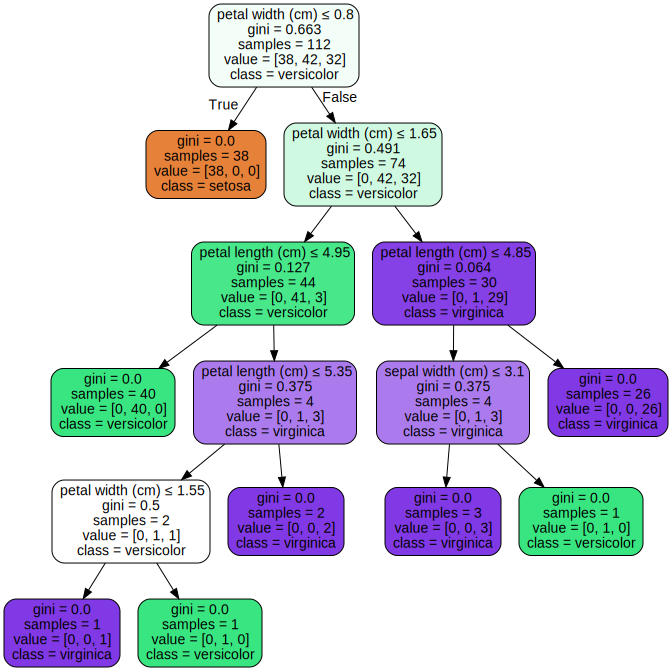

In [9]:
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)

dot_data = export_graphviz(dt, out_file=None, 
                           feature_names=X.columns,  
                           class_names=dataset.target_names,  
                           filled=True, rounded=True,  
                           special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

In [10]:
sklearn_y_preds = dt.predict(X_test)
print(f"Sklearn Implementation:\nACCURACY: {accuracy_score(y_test, sklearn_y_preds)}")

Sklearn Implementation:
ACCURACY: 0.9736842105263158


In [17]:
def gini_index(p):
    return 1 - p**2 - ( 1 - p)**2 

def entropy(p):
    p = 1 - 1e-15 if p > 1 - 1e-15 else p
    p = 1e-15 if p < 1e-15 else p
    return - p * np.log(p) - (1-p) * np.log(1-p)

def infomation_gain(p, p_left,p_right, left_ratio, right_ratio, metric = "gini"):
    if metric == "gini":
        ig = gini_index(p) - left_ratio * gini_index(p_left) -  right_ratio * gini_index(p_right)
    else:
        ig = entropy(p) - left_ratio * entropy(p_left) -  right_ratio * entropy(p_right)
    return ig


In [66]:
def build_stump(X, y):
    print("build_stump",)
    n, m = X.shape
    # X_train = X_train.values
    metric = "gini"

    best_splitting_feature = 0
    best_splitting_feature_value = 0
    best_information_gain = 0

    for i in range(m):
        feature = X[:, i]
        for splitting in np.unique(feature):
            left  = y[feature < splitting]
            right = y[feature >= splitting]
            p = 1.0 * y.sum()/ y.size
            p_left = 1.0 * left.sum()/left.size
            p_right = 1.0 *right.sum()/right.size
            left_ratio , right_ratio = 1.0 * left.size/y.size, 1.0 * right.size/y.size
            ig = infomation_gain(p, p_left, p_right, left_ratio, right_ratio, metric)
            if ig >=  best_information_gain:
                best_information_gain = ig
                best_splitting_feature = i
                best_splitting_feature_value = splitting
                
    question = f"feature {best_splitting_feature}  <= {best_splitting_feature_value}"
    print("question", question)
    row_idex = (X[:, best_splitting_feature] <= best_splitting_feature_value)
    
    if row_idex.sum() == 0 or row_idex.sum() == X.shape[0]:
        print("null sub tree, row_idex.shape", row_idex.shape)
        classes, counts = np.unique(y, return_counts=True)
        left_leaf = classes[counts.argmax()]
        return left_leaf
    print("y[row_idex],", y[row_idex].shape)
    classes, counts = np.unique(y[row_idex], return_counts=True)
    left_leaf = classes[counts.argmax()]
    
    classes, counts = np.unique(y[~row_idex], return_counts=True)
    right_leaf = classes[counts.argmax()]
    
    left_tree = build_stump(X[row_idex], y[row_idex])
    right_tree = build_stump(X[~row_idex], y[~row_idex])
    
    if left_tree == right_tree:
        print("left_leaf == right_leaf")
        sub_tree = left_leaf
    else:
        print("Alert!!!")
        sub_tree = {question: [left_tree, right_tree]}
    return sub_tree


In [74]:
X = X_train.values
y = np.zeros((112, 1))
y[y_train == "setosa"] = 1
y[y_train == "versicolor"] = 1

In [75]:
# X = X.values
y = y.reshape(-1,1)
aa = build_stump(X, y)
aa

build_stump
question feature 3  <= 1.7
y[row_idex], (83, 1)
build_stump
question feature 2  <= 5.0
y[row_idex], (80, 1)
build_stump
question feature 3  <= 1.7
null sub tree, row_idex.shape (80,)
build_stump
question feature 2  <= 5.6
y[row_idex], (2, 1)
build_stump
question feature 3  <= 1.6
null sub tree, row_idex.shape (2,)
build_stump
question feature 0  <= 0
null sub tree, row_idex.shape (1,)
left_leaf == right_leaf
Alert!!!
build_stump
question feature 2  <= 4.9
y[row_idex], (6, 1)
build_stump
question feature 1  <= 3.2
null sub tree, row_idex.shape (6,)
build_stump
question feature 3  <= 2.5
null sub tree, row_idex.shape (23,)
left_leaf == right_leaf
Alert!!!


/Users/shihuanzhao/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


{'feature 3  <= 1.7': [{'feature 2  <= 5.0': [1.0, 0.0]}, 0.0]}

In [72]:
cond = X[:, 3] <= 1
y[cond].sum(), y[~cond].sum()

(38.0, 0.0)

In [73]:
np.unique(y_train)

array(['setosa', 'versicolor', 'virginica'], dtype=object)